In [1]:
import sys
import warnings

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("darkgrid")

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA, KernelPCA
from sklearn.metrics import accuracy_score, matthews_corrcoef
from sklearn.model_selection import cross_val_score, cross_validate, StratifiedKFold
from sklearn.model_selection import GridSearchCV


from imblearn.pipeline import Pipeline
from imblearn.combine import SMOTEENN, SMOTETomek
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

from sklearn.svm import SVC

sys.path.append("../../")

from helpers.split import make_train_test_split, tag_label_feature_split
from helpers.assess import make_classification_report, make_confusion_matrix

DATASET_FOLDER = "../../datasets/"

In [2]:
# read a data set
df = pd.read_pickle(DATASET_FOLDER + "dataset_09_pvtt_mean_cov_icov.pickle")

In [3]:
# get labels, a label encoder and features
_, (y, le), X = tag_label_feature_split(df, label_format="encoded")

In [4]:
pd.Series(y).value_counts()

7    5343
1    5276
9    4000
4    2126
5    1552
8     985
6     831
0     468
2     409
3     361
dtype: int64

In [5]:
# review the shapes
print(f"{X.shape= } {y.shape= }")

X.shape= (21351, 361) y.shape= (21351,)


In [6]:
# split the data for training and testing with shuffling and stratification
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=1962, shuffle=True, stratify=y
)

In [7]:
# review the shapes
print(f"{X_train.shape = }\t{y_train.shape = }")
print(f"{X_test.shape =  }\t{y_test.shape =  }")

X_train.shape = (17080, 361)	y_train.shape = (17080,)
X_test.shape =  (4271, 361)	y_test.shape =  (4271,)


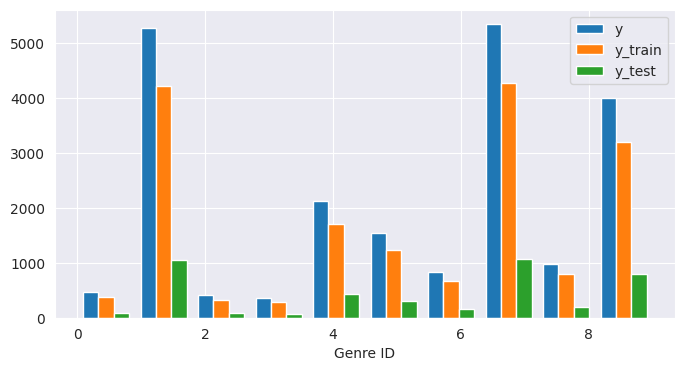

In [8]:
plt.figure(figsize=(8,4))
plt.hist([y, y_train, y_test],
         label=['y', 'y_train', 'y_test'])
plt.xlabel("Genre ID")
plt.legend()
plt.show()

In [9]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

pca=PCA(random_state=1962, n_components=.95)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

In [ ]:
param_grid = [
  {'C': [1, 10, 100, 1000],
   'gamma': [0.001, 0.0001],
   'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
   'class_weight': ['balanced'],
   'random_state': [1962]
  }]

grid = GridSearchCV(SVC(), param_grid, scoring='matthews_corrcoef', n_jobs=-1, verbose=4)
grid.fit(X_train_pca, y_train)

In [ ]:
grid.best_score_

In [ ]:
grid.best_params_

In [ ]:
param_grid = [
  {'C': [1, 10, 100, 1000],
   'gamma': [0.001, 0.0001],
   'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
   'class_weight': ['balanced'],
   'random_state': [1962]
  }]

grid_2 = GridSearchCV(SVC(), param_grid, scoring='matthews_corrcoef', n_jobs=-1, verbose=4)
grid_2.fit(X_train_scaled, y_train)

In [ ]:
print(grid_2.best_score_)
print(grid_2.best_params_)

In [ ]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=1962)


classifiers = []

for train_idx, validate_idx in skf.split(X_train, y_train):
    X_fold_train, X_fold_validate = X_train_pca[train_idx], X_train_pca[validate_idx]
    y_fold_train, y_fold_validate = y[train_idx], y[validate_idx]
    
    print ("create classifier")
    classifier = SVC(class_weight='balanced')
    
    classifier.fit(X_fold_train, y_fold_train)
    classifiers.append(classifier)
    

In [ ]:
classifiers[0].predict(X_test_pca)

In [ ]:
test_model = classifiers[4]
test_model_results = test_model.evals_result()
for key, val in test_model_results.items():
    print(key)

In [ ]:
train_results=test_model_results['validation_0']
test_results=test_model_results['validation_1']

In [ ]:
plt.plot(train_results['mlogloss'], label='train')
plt.plot(test_results['mlogloss'], label='test')
plt.legend()
plt.show()

In [ ]:
plt.plot(train_results['auc'], label='train')
plt.plot(test_results['auc'], label='test')
plt.legend()
plt.show()

In [ ]:
test_model=classifiers[0]
accuracy_score(y_test, test_model.predict(X_test_pca))

In [ ]:
matthews_corrcoef(y_test, test_model.predict(X_test_pca))